In [21]:
#!/usr/bin/env python3
import numpy as np
from io import StringIO

# Signature: Kefu Zhu

NUM_FEATURES = 124 #features are 1 through 123 (123 only in test set), +1 for the bias
DATA_PATH = "/u/cs246/data/adult/" #TODO: if doing development somewhere other than the cycle server, change this to the directory where a7a.train, a7a.dev, and a7a.test are
# DATA_PATH = "adult/"

#returns the label and feature value vector for one datapoint (represented as a line (string) from the data file)
def parse_line(line):
    tokens = line.split()
    x = np.zeros(NUM_FEATURES)
    y = int(tokens[0])
    y = max(y,0) #treat -1 as 0 instead, because sigmoid's range is 0-1
    for t in tokens[1:]:
        parts = t.split(':')
        feature = int(parts[0])
        value = int(parts[1])
        x[feature-1] = value
    x[-1] = 1 #bias
    return y, x

#return labels and feature vectors for all datapoints in the given file
def parse_data(filename):
    with open(filename, 'r') as f:
        vals = [parse_line(line) for line in f]
        (ys, xs) = ([v[0] for v in vals],[v[1] for v in vals])
        return np.asarray([ys],dtype=np.float32).T, np.asarray(xs,dtype=np.float32).reshape(len(xs),NUM_FEATURES,1) #returns a tuple, first is an array of labels, second is an array of feature vectors

def init_model(weight_files,hidden_dim,seed):
    w1 = None
    w2 = None

    if weight_files:
        with open(weights_files[0], 'r') as f1:
            w1 = np.loadtxt(f1)
        with open(weights_files[1], 'r') as f2:
            w2 = np.loadtxt(f2)
            w2 = w2.reshape(1,len(w2))
    else:
        #TODO (optional): If you want, you can experiment with a different random initialization. As-is, each weight is uniformly sampled from [-0.5,0.5).
        np.random.seed(seed)
        w1 = np.random.rand(hidden_dim, NUM_FEATURES) #bias included in NUM_FEATURES
        w2 = np.random.rand(1, hidden_dim + 1) #add bias column

    #At this point, w1 has shape (hidden_dim, NUM_FEATURES) and w2 has shape (1, hidden_dim + 1). In both, the last column is the bias weights.

    #TODO: Replace this with whatever you want to use to represent the network; you could use use a tuple of (w1,w2), make a class, etc.
    model = (w1,w2)

    return model

def forward(x,w1,w2):

    # Record a1
    a1 = np.dot(w1,x)
    # Construct the hidden layer (with bias term)
    hidden_layer = np.append(sigmoid(a1),1)
    # Record a2
    a2 = np.dot(w2,hidden_layer)
    # hidden_layer -> yhat
    y_hat = sigmoid(a2)

    return y_hat,hidden_layer,a1,a2

def backprop(x,y,y_hat,hidden_layer,w1,w2,a1,a2,lr):
    '''
    '''

    # 1-Hidden Layer Nerual Network Structure:
    # ----------------------------------------------------------------
    # x = z0
    # x*w1 = a1, sigmoid(a1) = z1 (hidden layer)
    # z1*w2 = a2, sigmoid(a2) = yhat

    # Step 1
    # ----------------------------------------------------------------
    # Calculate the gradient and update w2 (except the bias term)

    # (1) Error function: E = 0.5(y_hat - y)^2
    # (2) yhat = sigmoid(a2)
    # (3) a2 = w2·z1 (z1 = hidden_layer)

    # Chain Rule: dw2(E) = dyhat(E)·dw2(yhat)
    #                    = dyhat(E)·[da2(yhat)·dw2(a2)]
    #                    = delta_2·dw2(a2) 
    #             - delta_2 = dyhat(E)·da2(yhat)
    #               - dyhat(E) = yhat - y
    #               - da2(yhat) = sigmoid_derivative(yhat)
    #             - dw2(a2) = z1 (hidden_layer)

    # Step 2
    # ----------------------------------------------------------------
    # Calculate the gradient and update w1 (except the bias term)

    # Chain Rule: dw1(E) = da1(E)·dw1(a1)      
    #                    = [dz1(E)·da1(z1)]·dw1(a1)
    #                    = [da2(E)·dz1(a2)]·da1(z1)·dw1(a1)
    #                    = [da2(E)]·dz1(a2)·da1(z1)·dw1(a1)
    #                    = [dyhat(E)·da2(yhat)]·dz1(a2)·da1(z1)·dw1(a1)
    #                    = delta_2·dz1(a2)·da1(z1)·dw1(a1)
    #                    = delta_1·dw1(a1)
    #             - delta_1 = delta_2·dz1(a2)·da1(z1)
    #               - delta_2 = see Step 1
    #               - dz1(a2) = w2 (Note: we need to trim away the bias term from w2)
    #               - da1(z1) = sigmoid_derivative(a1)
    #             - dw1(a1) = z0 (x)

    delta_2 = np.dot((y_hat - y), sigmoid_derivative(a2))
    dw2 = delta_2 * hidden_layer
    delta_1 = (np.transpose(w2)[:-1] * delta_2) * sigmoid_derivative(a1)
    dw1 = np.dot(delta_1, np.transpose(x))

    w1 = w1 - lr * dw1
    w2 = w2 - lr * dw2

    return w1,w2

def sigmoid(x):
    '''
    This function takes an input and transforms it using sigmoid function
    '''

    # return the sigmoid transformation
    return 1/(1+np.exp(-x))

def sigmoid_derivative(x):
    '''
    This function takes an input and return the derivative of its sigmoid function
    '''

    # return the derivative
    return (1-sigmoid(x))*sigmoid(x) 

def test_accuracy(model, test_ys, test_xs):
    accuracy = 0.0
    #TODO: Implement accuracy computation of given model on the test data

    # Extract the weight vector from model
    w1,w2 = extract_weights(model)

    # Predict the value of y for test dataset based on given weight vector
    test_yhat = [forward(x,w1,w2)[0] for x in test_xs]
    
    # Convert the prediction probablity to [0,1]
    test_yhat = [0 if yhat <= 0.5 else 1 for yhat in test_yhat]
    # Format test_yhat to be the same as test_ys
    test_yhat = np.transpose(np.array([test_yhat]))    
    # Compute the classification accuracy in the test set
    accuracy = float(sum(test_yhat == test_ys)/len(test_ys))

    # Return the accuracy
    return accuracy


def extract_weights(model):
    w1 = None
    w2 = None
    #TODO: Extract the two weight matrices from the model and return them (they should be the same type and shape as they were in init_model, but now they have been updated during training)
    w1,w2 = model
    return (w1,w2)

In [223]:
def train_model(model, train_ys, train_xs, dev_ys, dev_xs, lr, iterations):
    #TODO: Implement training for the given model, respecting args

    # If we use dev set
    if dev_xs is not None:
        # Initialize a vector to store experiment result
        error_iteration = np.empty(iterations)
        # Initialize the best model (Use the original model)
        best_model = model
        print('Learning Rate = {}, Iteration = {}'.format(lr,iterations))
        print('-'*30)
        # Extract the weights
        w1,w2 = extract_weights(model)
        # Track the number of iterations
        num_iter = 1
        # While the number of iteractions does not go beyond the maximum
        while num_iter <= iterations:
            # Initialize the error variable to zero
            error = 0
            # Loop through each pair of (x,y) in the training dataset
            for x,y in zip(train_xs,train_ys):
                # Feed forward
                y_hat,hidden_layer,a1,a2 = forward(x,w1,w2)
                # Error function: E = 0.5(y_hat - y)^2
                error += (1/2) * np.power((y_hat - y), 2)
                # Backpropagation
                w1,w2 = backprop(x,y,y_hat,hidden_layer,w1,w2,a1,a2,lr)
            # Record the current error
            error_iteration[num_iter-1] = error
            # Show the training progress
            if iterations <= 10: #
                print('Iteration #{}: {}.'.format(num_iter,float(np.round(error,2))))
            else:
                if num_iter % round(iterations/10) == 0:
                    print('Iteration #{}: {}.'.format(num_iter,float(np.round(error,2))))
            # Increment the iteraction number
            num_iter += 1

            # Compare the performance between the current weight vector and the best weight vector so far
            if test_accuracy(best_model, dev_ys, dev_xs) < test_accuracy((w1,w2), dev_ys, dev_xs):
                # Make a deep copy of the current weight vector and set it as the best one
                best_model = (np.copy(w1),np.copy(w2))
        # Print the accuracy of current best model
        print('Best model dev accuracy: {}'.format(test_accuracy(best_model, dev_ys, dev_xs)))
        print('-'*30)
        # Return the best model
        return best_model,error_iteration

    # If dev set is not used
    else:
        # Extract the weights
        w1,w2 = extract_weights(model)
        # Track the number of iterations
        num_iter = 1
        # Initialize the hidden layer (+1 for the bias term)
        # hidden_layer = np.ones(len(w1)+1)
        # While the number of iteractions does not go beyond the maximum
        while num_iter <= args.iterations:
            # Initialize the error variable to zero
            error = 0
            # Loop through each pair of (x,y) in the training dataset
            for x,y in zip(train_xs,train_ys):
                # Feed forward
                # y_hat,hidden_layer,a1,a2 = forward(x,hidden_layer,w1,w2)
                y_hat,hidden_layer,a1,a2 = forward(x,w1,w2)
                # Error function: E = 0.5(y_hat - y)^2
                error += (1/2) * np.power((y_hat - y), 2)
                # Backpropagation
                w1,w2 = backprop(x,y,y_hat,hidden_layer,w1,w2,a1,a2,args.lr)
            
            # Show the training progress
            if args.iterations <= 10: #
                print('Iteration #{}: {}.'.format(num_iter,float(np.round(error,2))))
            else:
                if num_iter % round(args.iterations/10) == 0:
                    print('Iteration #{}: {}.'.format(num_iter,float(np.round(error,2))))
            # Increment the iteraction number
            num_iter += 1
        # Model (w1,w2,hidden_layer) after the training
        model = (w1,w2)
    # Return the model
    return model

In [224]:
train_ys, train_xs = parse_data('adult/a7a.train')
dev_ys, dev_xs= parse_data('adult/a7a.dev')
test_ys, test_xs = parse_data('adult/a7a.test')

In [225]:
model = init_model(None,5,123)

In [226]:
model_1_lr3_iter100,error_1_lr3_iter100 = train_model(model, train_ys, train_xs, dev_ys, dev_xs, lr=3, iterations=200)

Learning Rate = 3, Iteration = 200
------------------------------
Iteration #20: 915.69.
Iteration #40: 902.83.
Iteration #60: 878.83.
Iteration #80: 874.48.
Iteration #100: 862.17.
Iteration #120: 866.45.
Iteration #140: 860.47.
Iteration #160: 864.84.
Iteration #180: 861.53.
Iteration #200: 858.79.
Best model dev accuracy: 0.84275
------------------------------


Iteration #: 169, Minimum Loss:857.5309131636909


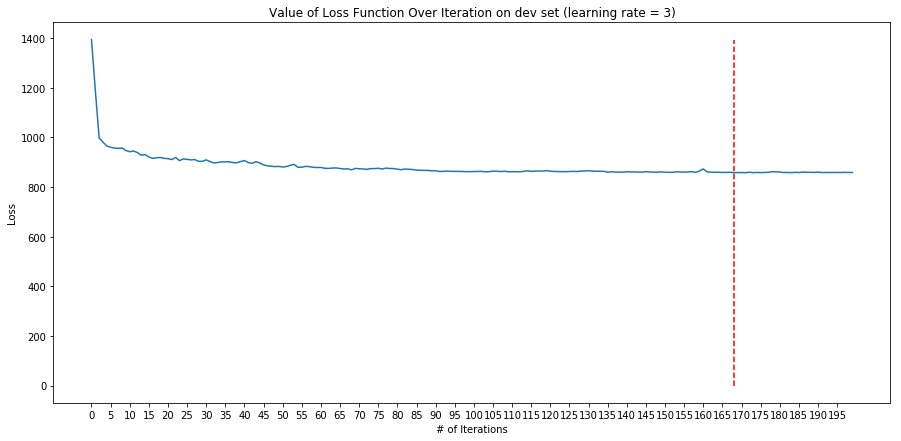

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot the model performance (learning rate = 1)
fig, ax = plt.subplots(figsize = (15,7))
sns.lineplot(data = error_1_lr3_iter100)
ax.vlines(np.argmin(error_1_lr3_iter100), ymin = 0, ymax = max(error_1_lr3_iter100), colors = 'red', linestyles='dashed')
ax.set_title('Value of Loss Function Over Iteration on dev set (learning rate = 3)'); 
ax.set_xlabel('# of Iterations');
ax.set_ylabel('Loss');
ax.set_xticks(range(0,len(error_1_lr3_iter100),5));

print('Iteration #: {}, Minimum Loss:{}'.format(np.argmin(error_1_lr3_iter100)+1,min(error_1_lr3_iter100)))

In [228]:
# Trim the record of loss value to the optimal
error_1_lr3_iter100 = error_1_lr3_iter100[:np.argmin(error_1_lr3_iter100)]

In [229]:
def train_model(model, train_ys, train_xs, dev_ys, dev_xs, lr_grid, iterations):
    #TODO: Implement training for the given model, respecting args

    # If we use dev set
    if dev_xs is not None:
        import time
        # Record start time of experiment
        start = time.time()
        # Initialize variables to store the best experiment result
        best_error_iteration = None
        best_lr = None
        best_iter = None
        # Initialize the global best model (Use the original model)
        global_best_model = extract_weights(model)
        # Experiment with different learning rate
        for lr in lr_grid:
            # Initialize the local variables for experiment result using current learning rate
            local_best_model = extract_weights(model)
            local_iter = None
            # Initialize a vector to store the current experiment result
            error_iteration = np.empty(iterations)
            print('Learning Rate = {}'.format(lr))
            print('-'*30)
            # Extract the weights
            w1,w2 = extract_weights(model)
            # Track the number of iterations
            num_iter = 1
            # While the number of iteractions does not go beyond the maximum
            while num_iter <= iterations:
                # Initialize the error variable to zero
                error = 0
                # Loop through each pair of (x,y) in the training dataset
                for x,y in zip(train_xs,train_ys):
                    # Feed forward
                    y_hat,hidden_layer,a1,a2 = forward(x,w1,w2)
                    # Error function: E = 0.5(y_hat - y)^2
                    error += (1/2) * np.power((y_hat - y), 2)
                    # Backpropagation
                    w1,w2 = backprop(x,y,y_hat,hidden_layer,w1,w2,a1,a2,lr)
                # Record the current error
                error_iteration[num_iter-1] = error
                # Show the training progress
                if iterations <= 10: #
                    print('Iteration #{}: {}.'.format(num_iter,float(np.round(error,2))))
                else:
                    if num_iter % round(iterations/10) == 0:
                        print('Iteration #{}: {}.'.format(num_iter,float(np.round(error,2))))
                # Increment the iteraction number
                num_iter += 1

                # Compare the performance between the current weight vector and the best weight vector so far
                if test_accuracy(local_best_model, dev_ys, dev_xs) < test_accuracy((w1,w2), dev_ys, dev_xs):
                    # Make a deep copy of the current weight vector and set it as the best local model
                    local_best_model = (np.copy(w1),np.copy(w2))
                    local_iter = num_iter
            
            # Print the accuracy of current best model
            print('Best model dev accuracy: {}'.format(test_accuracy(local_best_model, dev_ys, dev_xs)))
            print('-'*30)

            # If the current model is better than the global best model
            if test_accuracy(global_best_model, dev_ys, dev_xs) < test_accuracy(local_best_model, dev_ys, dev_xs):
                # Reset values of variables to store the best experiment result
                best_error_iteration = np.copy(error_iteration)
                best_lr = lr
                best_iter = local_iter
        # Record end time of experiment
        end = time.time()
        # Show the experiment time
        print('Experiment took {} minutes'.format(round((end-start)/60),2))
        # Print the accuracy of current best model
        print('Best model dev accuracy: {}, Learning Rate = {}, Iteration = {}'
              .format(test_accuracy(global_best_model, dev_ys, dev_xs),
                      best_lr,
                      best_iter))
        # Return the best model
        return global_best_model, best_error_iteration

    # If dev set is not used
    else:
        # Extract the weights
        w1,w2 = extract_weights(model)
        # Track the number of iterations
        num_iter = 1
        # Initialize the hidden layer (+1 for the bias term)
        # hidden_layer = np.ones(len(w1)+1)
        # While the number of iteractions does not go beyond the maximum
        while num_iter <= args.iterations:
            # Initialize the error variable to zero
            error = 0
            # Loop through each pair of (x,y) in the training dataset
            for x,y in zip(train_xs,train_ys):
                # Feed forward
                # y_hat,hidden_layer,a1,a2 = forward(x,hidden_layer,w1,w2)
                y_hat,hidden_layer,a1,a2 = forward(x,w1,w2)
                # Error function: E = 0.5(y_hat - y)^2
                error += (1/2) * np.power((y_hat - y), 2)
                # Backpropagation
                w1,w2 = backprop(x,y,y_hat,hidden_layer,w1,w2,a1,a2,args.lr)
            
            # Show the training progress
            if args.iterations <= 10: #
                print('Iteration #{}: {}.'.format(num_iter,float(np.round(error,2))))
            else:
                if num_iter % round(args.iterations/10) == 0:
                    print('Iteration #{}: {}.'.format(num_iter,float(np.round(error,2))))
            # Increment the iteraction number
            num_iter += 1
        # Model (w1,w2,hidden_layer) after the training
        model = (w1,w2)
    # Return the model
    return model

In [230]:
iterations = 200
lr_grid =  [0.01,0.5,1,2]

In [231]:
model_2,error_2 = train_model(model_1_lr3_iter100, train_ys, train_xs, dev_ys, dev_xs, lr_grid, iterations)

Learning Rate = 0.01
------------------------------
Iteration #20: 857.86.
Iteration #40: 848.59.
Iteration #60: 841.94.
Iteration #80: 839.09.
Iteration #100: 837.12.
Iteration #120: 835.47.
Iteration #140: 834.05.
Iteration #160: 832.81.
Iteration #180: 831.72.
Iteration #200: 830.75.
Best model dev accuracy: 0.845875
------------------------------
Learning Rate = 0.5
------------------------------
Iteration #20: 828.2.
Iteration #40: 820.51.
Iteration #60: 815.72.
Iteration #80: 812.63.
Iteration #100: 810.39.
Iteration #120: 808.58.
Iteration #140: 807.08.
Iteration #160: 806.02.
Iteration #180: 805.09.
Iteration #200: 804.12.
Best model dev accuracy: 0.84275
------------------------------
Learning Rate = 1
------------------------------
Iteration #20: 840.45.
Iteration #40: 831.5.
Iteration #60: 826.51.
Iteration #80: 823.6.
Iteration #100: 821.42.
Iteration #120: 819.51.
Iteration #140: 818.59.
Iteration #160: 817.36.
Iteration #180: 816.14.
Iteration #200: 815.13.
Best model dev

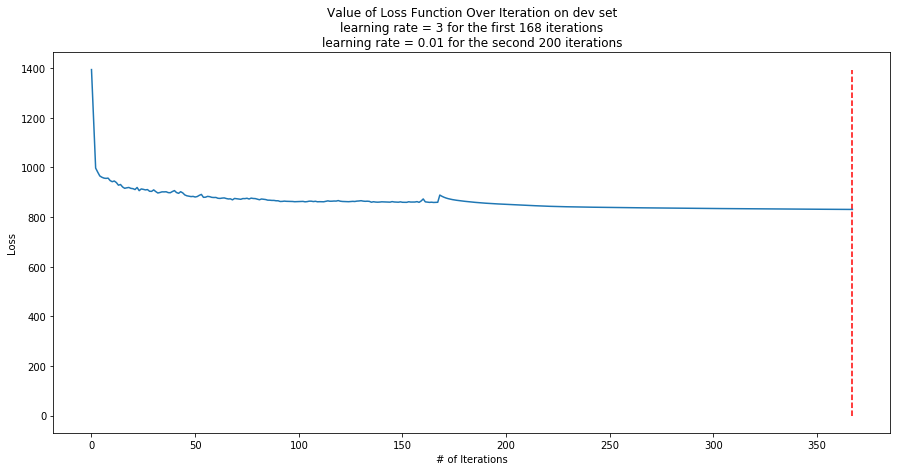

In [195]:
# Combine the change of error in both stages
error = np.append(error_1_lr3_iter100,error_2)
# Plot the model performance (learning rate = 1)
fig, ax = plt.subplots(figsize = (15,7))
sns.lineplot(data = error)
ax.vlines(np.argmin(error), ymin = 0, ymax = max(error), colors = 'red', linestyles='dashed')
ax.set_title('Value of Loss Function Over Iteration on dev set\nlearning rate = 3 for the first 168 iterations\nlearning rate = 0.01 for the second 200 iterations'); 
ax.set_xlabel('# of Iterations');
ax.set_ylabel('Loss');
ax.set_xticks(range(0,len(error)+1,50));

In [197]:
print('Iteration #: {}, Minimum Loss:{}'.format(np.argmin(error)+1,min(error)))

Iteration #: 368, Minimum Loss:830.7514027533523


In [198]:
def train_model(model, train_ys, train_xs, dev_ys, dev_xs, lr, iterations):
    #TODO: Implement training for the given model, respecting args

    # If we use dev set
    if dev_xs is not None:
        # Initialize a vector to store experiment result
        error_iteration = np.empty(iterations)
        # Initialize the best model (Use the original model)
        best_model = model
        print('Learning Rate = {}, Iteration = {}'.format(lr,iterations))
        print('-'*30)
        # Extract the weights
        w1,w2 = extract_weights(model)
        # Track the number of iterations
        num_iter = 1
        # While the number of iteractions does not go beyond the maximum
        while num_iter <= iterations:
            # Initialize the error variable to zero
            error = 0
            # Loop through each pair of (x,y) in the training dataset
            for x,y in zip(train_xs,train_ys):
                # Feed forward
                y_hat,hidden_layer,a1,a2 = forward(x,w1,w2)
                # Error function: E = 0.5(y_hat - y)^2
                error += (1/2) * np.power((y_hat - y), 2)
                # Backpropagation
                w1,w2 = backprop(x,y,y_hat,hidden_layer,w1,w2,a1,a2,lr)
            # Record the current error
            error_iteration[num_iter-1] = error
            # Show the training progress
            if iterations <= 10: #
                print('Iteration #{}: {}.'.format(num_iter,float(np.round(error,2))))
            else:
                if num_iter % round(iterations/10) == 0:
                    print('Iteration #{}: {}.'.format(num_iter,float(np.round(error,2))))
            # Increment the iteraction number
            num_iter += 1

            # Compare the performance between the current weight vector and the best weight vector so far
            if test_accuracy(best_model, dev_ys, dev_xs) < test_accuracy((w1,w2), dev_ys, dev_xs):
                # Make a deep copy of the current weight vector and set it as the best one
                best_model = (np.copy(w1),np.copy(w2))
        # Print the accuracy of current best model
        print('Best model dev accuracy: {}'.format(test_accuracy(best_model, dev_ys, dev_xs)))
        print('-'*30)
        # Return the best model
        return best_model,error_iteration

    # If dev set is not used
    else:
        # Extract the weights
        w1,w2 = extract_weights(model)
        # Track the number of iterations
        num_iter = 1
        # Initialize the hidden layer (+1 for the bias term)
        # hidden_layer = np.ones(len(w1)+1)
        # While the number of iteractions does not go beyond the maximum
        while num_iter <= args.iterations:
            # Initialize the error variable to zero
            error = 0
            # Loop through each pair of (x,y) in the training dataset
            for x,y in zip(train_xs,train_ys):
                # Feed forward
                # y_hat,hidden_layer,a1,a2 = forward(x,hidden_layer,w1,w2)
                y_hat,hidden_layer,a1,a2 = forward(x,w1,w2)
                # Error function: E = 0.5(y_hat - y)^2
                error += (1/2) * np.power((y_hat - y), 2)
                # Backpropagation
                w1,w2 = backprop(x,y,y_hat,hidden_layer,w1,w2,a1,a2,args.lr)
            
            # Show the training progress
            if args.iterations <= 10: #
                print('Iteration #{}: {}.'.format(num_iter,float(np.round(error,2))))
            else:
                if num_iter % round(args.iterations/10) == 0:
                    print('Iteration #{}: {}.'.format(num_iter,float(np.round(error,2))))
            # Increment the iteraction number
            num_iter += 1
        # Model (w1,w2,hidden_layer) after the training
        model = (w1,w2)
    # Return the model
    return model

In [199]:
train_ys, train_xs = parse_data('adult/a7a.train')
dev_ys, dev_xs= parse_data('adult/a7a.dev')
test_ys, test_xs = parse_data('adult/a7a.test')

In [200]:
model = init_model(None,3,123)

In [202]:
model_1_lr3_iter100,error_1_lr3_iter100 = train_model(model, train_ys, train_xs, dev_ys, dev_xs, lr=3, iterations=200)

Learning Rate = 3, Iteration = 200
------------------------------
Iteration #20: 932.3.
Iteration #40: 916.55.
Iteration #60: 911.51.
Iteration #80: 896.0.
Iteration #100: 890.59.
Iteration #120: 891.92.
Iteration #140: 892.99.
Iteration #160: 887.83.
Iteration #180: 886.17.
Iteration #200: 887.31.
Best model dev accuracy: 0.849375
------------------------------


Iteration #: 175, Minimum Loss:883.4218249789819


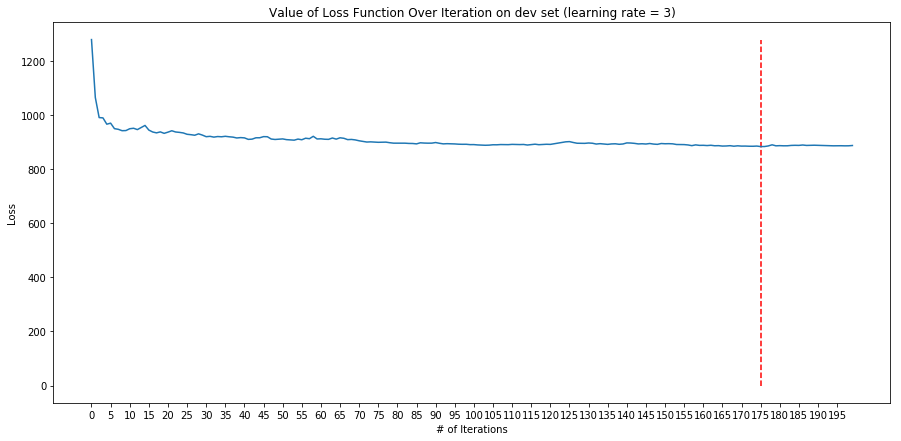

In [203]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot the model performance (learning rate = 1)
fig, ax = plt.subplots(figsize = (15,7))
sns.lineplot(data = error_1_lr3_iter100)
ax.vlines(np.argmin(error_1_lr3_iter100), ymin = 0, ymax = max(error_1_lr3_iter100), colors = 'red', linestyles='dashed')
ax.set_title('Value of Loss Function Over Iteration on dev set (learning rate = 3)'); 
ax.set_xlabel('# of Iterations');
ax.set_ylabel('Loss');
ax.set_xticks(range(0,len(error_1_lr3_iter100),5));

print('Iteration #: {}, Minimum Loss:{}'.format(np.argmin(error_1_lr3_iter100),min(error_1_lr3_iter100)))

In [204]:
# Trim the record of loss value to the optimal
error_1_lr3_iter100 = error_1_lr3_iter100[:np.argmin(error_1_lr3_iter100)]

In [206]:
def train_model(model, train_ys, train_xs, dev_ys, dev_xs, lr_grid, iterations):
    #TODO: Implement training for the given model, respecting args

    # If we use dev set
    if dev_xs is not None:
        import time
        # Record start time of experiment
        start = time.time()
        # Initialize variables to store the best experiment result
        best_error_iteration = None
        best_lr = None
        best_iter = None
        # Initialize the global best model (Use the original model)
        global_best_model = extract_weights(model)
        # Experiment with different learning rate
        for lr in lr_grid:
            # Initialize the local variables for experiment result using current learning rate
            local_best_model = extract_weights(model)
            local_iter = None
            # Initialize a vector to store the current experiment result
            error_iteration = np.empty(iterations)
            print('Learning Rate = {}'.format(lr))
            print('-'*30)
            # Extract the weights
            w1,w2 = extract_weights(model)
            # Track the number of iterations
            num_iter = 1
            # While the number of iteractions does not go beyond the maximum
            while num_iter <= iterations:
                # Initialize the error variable to zero
                error = 0
                # Loop through each pair of (x,y) in the training dataset
                for x,y in zip(train_xs,train_ys):
                    # Feed forward
                    y_hat,hidden_layer,a1,a2 = forward(x,w1,w2)
                    # Error function: E = 0.5(y_hat - y)^2
                    error += (1/2) * np.power((y_hat - y), 2)
                    # Backpropagation
                    w1,w2 = backprop(x,y,y_hat,hidden_layer,w1,w2,a1,a2,lr)
                # Record the current error
                error_iteration[num_iter-1] = error
                # Show the training progress
                if iterations <= 10: #
                    print('Iteration #{}: {}.'.format(num_iter,float(np.round(error,2))))
                else:
                    if num_iter % round(iterations/10) == 0:
                        print('Iteration #{}: {}.'.format(num_iter,float(np.round(error,2))))
                # Increment the iteraction number
                num_iter += 1

                # Compare the performance between the current weight vector and the best weight vector so far
                if test_accuracy(local_best_model, dev_ys, dev_xs) < test_accuracy((w1,w2), dev_ys, dev_xs):
                    # Make a deep copy of the current weight vector and set it as the best local model
                    local_best_model = (np.copy(w1),np.copy(w2))
                    local_iter = iterations
            
            # Print the accuracy of current best model
            print('Best model dev accuracy: {}'.format(test_accuracy(local_best_model, dev_ys, dev_xs)))
            print('-'*30)

            # If the current model is better than the global best model
            if test_accuracy(global_best_model, dev_ys, dev_xs) < test_accuracy(local_best_model, dev_ys, dev_xs):
                # Reset values of variables to store the best experiment result
                best_error_iteration = np.copy(error_iteration)
                best_lr = lr
                best_iter = local_iter
        # Record end time of experiment
        end = time.time()
        # Show the experiment time
        print('Experiment took {} minutes'.format(round((end-start)/60),2))
        # Print the accuracy of current best model
        print('Best model dev accuracy: {}, Learning Rate = {}, Iteration = {}'
              .format(test_accuracy(global_best_model, dev_ys, dev_xs),
                      best_lr,
                      best_iter))
        # Return the best model
        return global_best_model

    # If dev set is not used
    else:
        # Extract the weights
        w1,w2 = extract_weights(model)
        # Track the number of iterations
        num_iter = 1
        # Initialize the hidden layer (+1 for the bias term)
        # hidden_layer = np.ones(len(w1)+1)
        # While the number of iteractions does not go beyond the maximum
        while num_iter <= args.iterations:
            # Initialize the error variable to zero
            error = 0
            # Loop through each pair of (x,y) in the training dataset
            for x,y in zip(train_xs,train_ys):
                # Feed forward
                # y_hat,hidden_layer,a1,a2 = forward(x,hidden_layer,w1,w2)
                y_hat,hidden_layer,a1,a2 = forward(x,w1,w2)
                # Error function: E = 0.5(y_hat - y)^2
                error += (1/2) * np.power((y_hat - y), 2)
                # Backpropagation
                w1,w2 = backprop(x,y,y_hat,hidden_layer,w1,w2,a1,a2,args.lr)
            
            # Show the training progress
            if args.iterations <= 10: #
                print('Iteration #{}: {}.'.format(num_iter,float(np.round(error,2))))
            else:
                if num_iter % round(args.iterations/10) == 0:
                    print('Iteration #{}: {}.'.format(num_iter,float(np.round(error,2))))
            # Increment the iteraction number
            num_iter += 1
        # Model (w1,w2,hidden_layer) after the training
        model = (w1,w2)
    # Return the model
    return model

In [207]:
iterations = 200
lr_grid =  [0.01,0.5,1,2]

In [208]:
model_2,error_2 = train_model(model_1_lr3_iter100, train_ys, train_xs, dev_ys, dev_xs, lr_grid, iterations)

Learning Rate = 0.01
------------------------------
Iteration #20: 861.69.
Iteration #40: 858.41.
Iteration #60: 856.17.
Iteration #80: 854.48.
Iteration #100: 853.1.
Iteration #120: 851.93.
Iteration #140: 850.91.
Iteration #160: 850.01.
Iteration #180: 849.2.
Iteration #200: 848.46.
Best model dev accuracy: 0.849375
------------------------------
Learning Rate = 0.5
------------------------------
Iteration #20: 849.16.
Iteration #40: 843.28.
Iteration #60: 840.73.
Iteration #80: 838.9.
Iteration #100: 837.45.
Iteration #120: 836.24.
Iteration #140: 835.16.
Iteration #160: 834.14.
Iteration #180: 833.32.
Iteration #200: 832.65.
Best model dev accuracy: 0.849375
------------------------------
Learning Rate = 1
------------------------------
Iteration #20: 863.92.
Iteration #40: 859.67.
Iteration #60: 855.03.
Iteration #80: 851.72.
Iteration #100: 849.79.
Iteration #120: 848.45.
Iteration #140: 846.56.
Iteration #160: 845.62.
Iteration #180: 844.77.
Iteration #200: 844.22.
Best model de

In [213]:
def train_model(model, train_ys, train_xs, dev_ys, dev_xs, lr, iterations):
    #TODO: Implement training for the given model, respecting args

    # If we use dev set
    if dev_xs is not None:
        # Initialize a vector to store experiment result
        error_iteration = np.empty(iterations)
        # Initialize the best model (Use the original model)
        best_model = model
        print('Learning Rate = {}, Iteration = {}'.format(lr,iterations))
        print('-'*30)
        # Extract the weights
        w1,w2 = extract_weights(model)
        # Track the number of iterations
        num_iter = 1
        # While the number of iteractions does not go beyond the maximum
        while num_iter <= iterations:
            # Initialize the error variable to zero
            error = 0
            # Loop through each pair of (x,y) in the training dataset
            for x,y in zip(train_xs,train_ys):
                # Feed forward
                y_hat,hidden_layer,a1,a2 = forward(x,w1,w2)
                # Error function: E = 0.5(y_hat - y)^2
                error += (1/2) * np.power((y_hat - y), 2)
                # Backpropagation
                w1,w2 = backprop(x,y,y_hat,hidden_layer,w1,w2,a1,a2,lr)
            # Record the current error
            error_iteration[num_iter-1] = error
            # Show the training progress
            if iterations <= 10: #
                print('Iteration #{}: {}.'.format(num_iter,float(np.round(error,2))))
            else:
                if num_iter % round(iterations/10) == 0:
                    print('Iteration #{}: {}.'.format(num_iter,float(np.round(error,2))))
            # Increment the iteraction number
            num_iter += 1

            # Compare the performance between the current weight vector and the best weight vector so far
            if test_accuracy(best_model, dev_ys, dev_xs) < test_accuracy((w1,w2), dev_ys, dev_xs):
                # Make a deep copy of the current weight vector and set it as the best one
                best_model = (np.copy(w1),np.copy(w2))
        # Print the accuracy of current best model
        print('Best model dev accuracy: {}'.format(test_accuracy(best_model, dev_ys, dev_xs)))
        print('-'*30)
        # Return the best model
        return best_model,error_iteration

    # If dev set is not used
    else:
        # Extract the weights
        w1,w2 = extract_weights(model)
        # Track the number of iterations
        num_iter = 1
        # Initialize the hidden layer (+1 for the bias term)
        # hidden_layer = np.ones(len(w1)+1)
        # While the number of iteractions does not go beyond the maximum
        while num_iter <= args.iterations:
            # Initialize the error variable to zero
            error = 0
            # Loop through each pair of (x,y) in the training dataset
            for x,y in zip(train_xs,train_ys):
                # Feed forward
                # y_hat,hidden_layer,a1,a2 = forward(x,hidden_layer,w1,w2)
                y_hat,hidden_layer,a1,a2 = forward(x,w1,w2)
                # Error function: E = 0.5(y_hat - y)^2
                error += (1/2) * np.power((y_hat - y), 2)
                # Backpropagation
                w1,w2 = backprop(x,y,y_hat,hidden_layer,w1,w2,a1,a2,args.lr)
            
            # Show the training progress
            if args.iterations <= 10: #
                print('Iteration #{}: {}.'.format(num_iter,float(np.round(error,2))))
            else:
                if num_iter % round(args.iterations/10) == 0:
                    print('Iteration #{}: {}.'.format(num_iter,float(np.round(error,2))))
            # Increment the iteraction number
            num_iter += 1
        # Model (w1,w2,hidden_layer) after the training
        model = (w1,w2)
    # Return the model
    return model

In [214]:
train_ys, train_xs = parse_data('adult/a7a.train')
dev_ys, dev_xs= parse_data('adult/a7a.dev')
test_ys, test_xs = parse_data('adult/a7a.test')

In [215]:
model = init_model(None,25,123)

In [218]:
model_1_lr3_iter100,error_1_lr3_iter100 = train_model(model, train_ys, train_xs, dev_ys, dev_xs, lr=3, iterations=200)

Learning Rate = 3, Iteration = 200
------------------------------
Iteration #20: 1418.83.
Iteration #40: 1398.02.
Iteration #60: 1397.85.
Iteration #80: 1329.78.
Iteration #100: 1346.7.
Iteration #120: 1335.81.
Iteration #140: 1314.9.
Iteration #160: 1311.91.
Iteration #180: 1399.47.
Iteration #200: 1293.37.
Best model dev accuracy: 0.844625
------------------------------


Iteration #: 194, Minimum Loss:1282.8006566242575


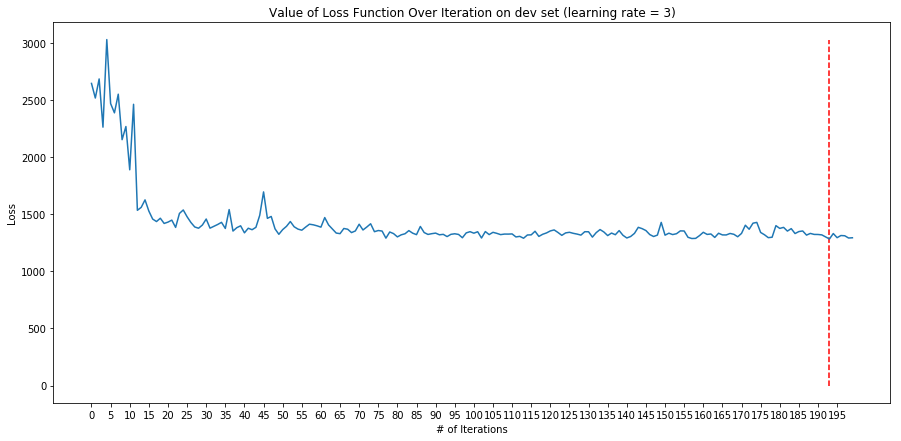

In [220]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot the model performance (learning rate = 1)
fig, ax = plt.subplots(figsize = (15,7))
sns.lineplot(data = error_1_lr3_iter100)
ax.vlines(np.argmin(error_1_lr3_iter100), ymin = 0, ymax = max(error_1_lr3_iter100), colors = 'red', linestyles='dashed')
ax.set_title('Value of Loss Function Over Iteration on dev set (learning rate = 3)'); 
ax.set_xlabel('# of Iterations');
ax.set_ylabel('Loss');
ax.set_xticks(range(0,len(error_1_lr3_iter100),5));

print('Iteration #: {}, Minimum Loss:{}'.format(np.argmin(error_1_lr3_iter100)+1,min(error_1_lr3_iter100)))